## Pipeline

In [1]:
#import library
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import pandas as pd
import os

from sklearn.metrics import average_precision_score

import tensorflow
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
# from tensorflow.keras.engine.topology import get_source_inputs
# from tensorflow.keras.utils import layer_utils
# from tensorflow.keras.utils.data_utils import get_file
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers, regularizers

import faster_rcnn
from faster_rcnn import RoiPoolingConv

#### Config setting(same as training)

In [2]:
class Config:

    def __init__(self):

        # Print the process or not
        self.verbose = True

        # Name of base network
        self.network = 'vgg'

        # Setting for data augmentation
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.rot_90 = False

        # Anchor box scales
            # Note that if im_size is smaller, anchor_box_scales should be scaled
            # Original anchor_box_scales in the paper is [128, 256, 512]
        self.anchor_box_scales = [64, 128, 256]

        # Anchor box ratios
        #self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
        
        self.anchor_box_ratios = [[1, 1], [1., 2.], [2., 1.], [1., 3.], [3., 1.], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
                                 

        # Size to resize the smallest side of the image
        # Original setting in paper is 600. Set to 300 in here to save training time
        self.im_size = 300

        # image channel-wise mean to subtract
        self.img_channel_mean = [92.775, 95.355, 92.233]
        self.img_scaling_factor = 1.0

        # number of ROIs at once
        self.num_rois = 4

        # stride at the RPN (this depends on the network configuration)
        self.rpn_stride = 16

        self.balanced_classes = False

        # scaling the stdev
        self.std_scaling = 4.0
        self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

        # overlaps for RPN
        self.rpn_min_overlap = 0.3
        self.rpn_max_overlap = 0.7

        # overlaps for classifier ROIs
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5

        # placeholder for the class mapping, automatically generated by the parser
        self.class_mapping = None

        self.model_path = None

In [3]:
base_path = './'
test_base_path = 'validation' # Directory to save the test images
config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

#### load config which was saved in training

In [4]:
with open(config_output_filename, 'rb') as f_in:
    C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

#### code to format input image as per configuration

In [5]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio

def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

#### load saved weights to model

In [6]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = faster_rcnn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = faster_rcnn.rpn_layer(shared_layers, num_anchors)

classifier = faster_rcnn.classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights('./model/Epoch_170.hdf5', by_name=True)
model_classifier.load_weights('./model/Epoch_170.hdf5', by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from ./model/model_frcnn_vgg.hdf5


#### class mapping gives unique color to each class so that it is distinguishable

In [7]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'truck', 1: 'vehicle fallback', 2: 'car', 3: 'motorcycle', 4: 'rider', 5: 'person', 6: 'bus', 7: 'bicycle', 8: 'autorickshaw', 9: 'animal', 10: 'traffic sign', 11: 'train', 12: 'traffic light', 13: 'caravan', 14: 'trailer', 15: 'bg'}


#### final method for predicting from image

In [12]:
def predict_image(imgs_path):
    # If the box classification value is less than this, we ignore this box
    bbox_threshold = 0.2

    for idx, img_name in enumerate(imgs_path):
        if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
            continue
        print(img_name)
        st = time.time()
        filepath = os.path.join(test_base_path, img_name)

        img = cv2.imread(filepath)

        X, ratio = format_img(img, C)

        X = np.transpose(X, (0, 2, 3, 1))

        # get output layer Y1, Y2 from the RPN and the feature maps F
        # Y1: y_rpn_cls
        # Y2: y_rpn_regr
        [Y1, Y2, F] = model_rpn.predict(X)

        # Get bboxes by applying NMS 
        # R.shape = (300, 4)
        R = faster_rcnn.rpn_to_roi(Y1, Y2, C, overlap_thresh=0.7)

        # convert from (x1,y1,x2,y2) to (x,y,w,h)
        R[:, 2] -= R[:, 0]
        R[:, 3] -= R[:, 1]

        # apply the spatial pyramid pooling to the proposed regions
        bboxes = {}
        probs = {}

        for jk in range(R.shape[0]//C.num_rois + 1):
            ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
            if ROIs.shape[1] == 0:
                break

            if jk == R.shape[0]//C.num_rois:
                #pad R
                curr_shape = ROIs.shape
                target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
                ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                ROIs_padded[:, :curr_shape[1], :] = ROIs
                ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                ROIs = ROIs_padded

            [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
            print(P_cls.shape)
            print(P_regr.shape)
            # Calculate bboxes coordinates on resized image
            for ii in range(P_cls.shape[1]):
                # Ignore 'bg' class
                if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                    continue

                cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

                if cls_name not in bboxes:
                    bboxes[cls_name] = []
                    probs[cls_name] = []

                (x, y, w, h) = ROIs[0, ii, :]

                cls_num = np.argmax(P_cls[0, ii, :])
                try:
                    (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                    tx /= C.classifier_regr_std[0]
                    ty /= C.classifier_regr_std[1]
                    tw /= C.classifier_regr_std[2]
                    th /= C.classifier_regr_std[3]
                    x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
                except:
                    pass
                bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
                probs[cls_name].append(np.max(P_cls[0, ii, :]))

        all_dets = []

        for key in bboxes:
            bbox = np.array(bboxes[key])

            new_boxes, new_probs = faster_rcnn.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
            for jk in range(new_boxes.shape[0]):
                (x1, y1, x2, y2) = new_boxes[jk,:]

                # Calculate real coordinates on original image
                (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

                cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

                textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
                all_dets.append((key,100*new_probs[jk]))

                (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
                textOrg = (real_x1, real_y1-0)

                cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
                cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
                cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

        print('Elapsed time = {}'.format(time.time() - st))
        print(all_dets)
        plt.figure(figsize=(10,10))
        plt.grid()
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.show()

BLR-2018-06-22-05-05-26_part_160000750.jpg
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)
(1, 4, 60)
(1, 4, 16)


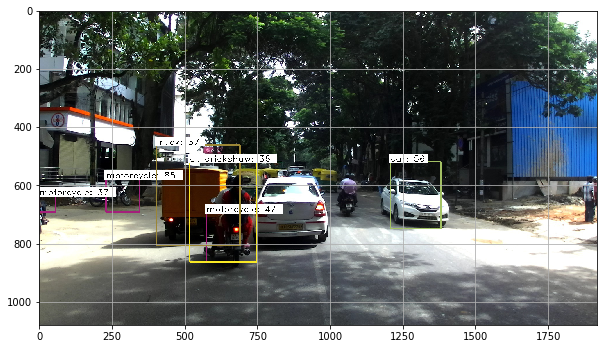

In [13]:
#image_list = ['BLR-2018-04-19_17-46-55_sideLeft0008220.jpg', '15-07-18-upload0019483.jpg', 'BLR-2018-06-05_08-39-44_frontNear0002760.jpg', 'BLR-2018-06-29-10-07-38_part_220000195.jpg', 'BLR-2018-06-22-05-05-26_part_160000750.jpg', 'BLR-2018-06-05_09-06-38_frontNear0006045.jpg']
image_list = ['BLR-2018-06-22-05-05-26_part_160000750.jpg']
predict_image(image_list)